# Bike Sharing Prediction

![title](images/bikes.png)

<br>

## Table of contents
[1. Context and objective](#section1)

[2. Exploring the datasets (EDA)](#section2)

* [A. Structure of the datasets](##section2A)
* [B. Data cleaning and preprocessing](##section2B)
* [C. Univariate analysis of the response variables](##section2C)
* [D. Bivariate analysis of the response variables](##section2D)
* [C. Correlation analysis](##section2E)

[3. Prediction](#section3)
* [A. Preparing the training dataset](##section3A)
* [B. Selecting and hyper tuning the models](##section3B)

[4. Conclusion and next steps](#section3)

<br>

<a id="Section1"></a>
## 1. Context and objective

This notebook is our final project for the class [MAP546P - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast the use of the city bikeshare system** in Washington. It is part of a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand#description).

<a id="Section2"></a>
## 2. Exploring the datasets (EDA)

<a id="Section3A"></a>
### A. Structure of the datasets

In [1]:
# Removing FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing libraries
import pandas as pd
import numpy as np
import datetime
from math import cos, pi
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, ParameterGrid
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xg

In [2]:
# Importing datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Merging datasets
train["is_train"] = [1 for x in range(train.shape[0])]
test["is_train"] = [0 for x in range(test.shape[0])]
datasets = pd.concat([train, test], sort=False)
datasets = datasets.reset_index(drop = True)

In [3]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,1.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.0


The **training** dataset has **~11k rows**, and **12 columns**:
- **<font color='grey'>datetime</font>** - hourly date + timestamp (from 2011-01-01 to 2012-12-19)
- **<font color='grey'>season</font>**
    - 1 = winter (end of december until end of march)
    - 2 = spring (end of march until end of june)
    - 3 = summer (end of june until end of september)
    - 4 = fall (end of septembre until end of december)
- **<font color='grey'>holiday</font>** - whether the day is considered a holiday
- **<font color='grey'>workingday</font>** - whether the day is neither a weekend nor holiday
- **<font color='grey'>weather</font>** 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **<font color='grey'>temp</font>** - temperature in Celsius (from 0.82 to 40)
- **<font color='grey'>atemp</font>** - "feels like" temperature in Celsius (from 0.76 to 45.45)
- **<font color='grey'>humidity</font>** - relative humidity (from 0% to 100%)
- **<font color='grey'>windspeed</font>** - wind speed (from 0 to 57)
- **<font color='grey'>casual</font>** - number of non-registered user rentals initiated (from 0 to 367)
- **<font color='grey'>registered</font>** - number of registered user rentals initiated (from 0 to 886)
- **<font color='grey'>count</font>** - number of total rentals (from 1 to 977)

In [4]:
test.shape

(6493, 10)

The **test** dataset has **~6k** rows.

In [5]:
pd.DataFrame(data=datasets.isna().sum(), columns=["Number of NAs"]).transpose()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
Number of NAs,0,0,0,0,0,0,0,0,0,6493,6493,6493,0


Neither the training nor the test dataset has **missing entries** (except of course for the response variables of the test dataset).

In [6]:
datasets[datasets["windspeed"] == 0].shape

(2180, 13)

However, we noticed that 2180 lines have a value of exactly 0 for the ```windspeed``` variable, which seems quite weird. These values could actually be missing, since the next value is bigger than 5.   
We will see later if we want to perform imputation on these values or if it is not necessary.

<a id="Section2B"></a>
### B. Data cleaning and preprocessing

In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1


We can create new variables from ```datetime```.

In [8]:
# Creating new variables from datetime
datasets["year"] = [int(datasets.datetime[x][0:4]) for x in range(datasets.shape[0])]
datasets["month"] = [int(datasets.datetime[x][5:7]) for x in range(datasets.shape[0])]
datasets["day"] = [int(datasets.datetime[x][8:10]) for x in range(datasets.shape[0])]
datasets["hour"] = [int(datasets.datetime[x][11:13]) for x in range(datasets.shape[0])]
datasets["weekday"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d').weekday() for x in range(datasets.shape[0])]
datasets["date"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d') for x in range(datasets.shape[0])]
datasets["dayoverall"] = [(datasets.date[x].date() - datetime.date(2011,1,1)).days for x in range(datasets.shape[0])]
datasets["weeknumber"] = [datasets.date[x].isocalendar()[1] for x in range(datasets.shape[0])]
datasets["monthyear"] = datasets.date.dt.to_period('M')

In [9]:
train = datasets[datasets.is_train == 1]
test = datasets[datasets.is_train == 0]

<a id="Section2C"></a>
### C. Univariate analysis of the response variables

Let's see how the response variables behave.

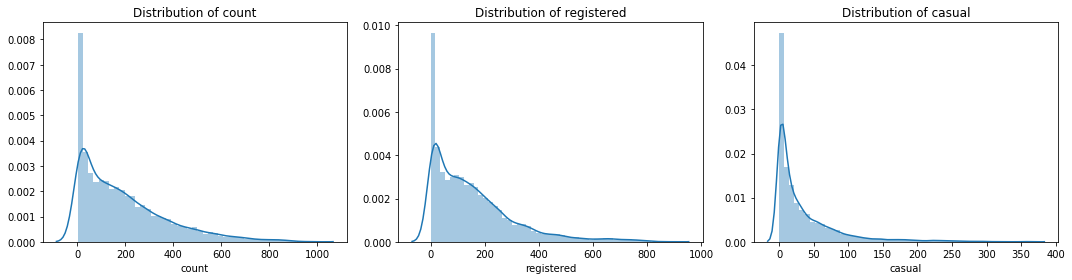

In [10]:
fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(15,4))

sn.distplot(train['count'], ax=axes[0])
axes[0].set(title="Distribution of count")

sn.distplot(train['registered'], ax=axes[1])
axes[1].set(title="Distribution of registered")

sn.distplot(train['casual'], ax=axes[2])
axes[2].set(title="Distribution of casual")

plt.tight_layout()

As we can see, the variables ```count```, ```registered``` and ```casual``` have positively skewed distributions: their medians are significantly lower than their means. Consequently, in our models we might want to log-transform them in order to get a gaussian distribution for these response variables.  

Instead of predicting the variable ```count```, we could predict separately ```casual``` and ```registered```, and add their predictions to obtain ```count```. This would be useful if their behaviors were dissimilar and if they needed to be modelled differently, which we will check later.

Let us now look for outliers: 

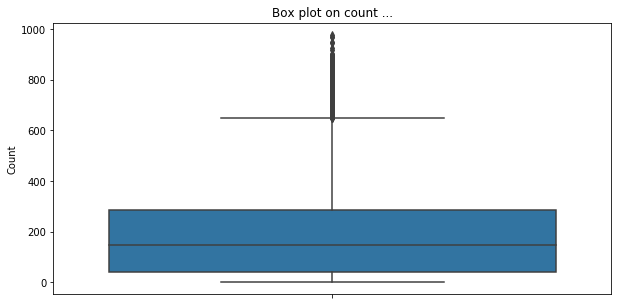

In [11]:
# Are there outliers?
fig, ax = plt.subplots(figsize = (10,5))
sn.boxplot(data=train, y="count", orient="v")
ax.set(ylabel='Count', title="Box plot on count ...")
plt.show()

One can observe some (high) outliers in the distribution of the ```count``` variable (below plot). They skew its distribution towards right.

In the next section, we will perform bivariate analysis to explore the behaviour of outliers and registered/casual users, to answer two questions:
- Should we discard the outliers?
- Should we perform two different models: one for the registered users and one for the casual users?

<a id="Section2D"></a>
### D. Bivariate analysis of the response variables

Let us first focus on outliers, by plotting count the total rental count as a function of categorical variable.  
Who are these outliers?

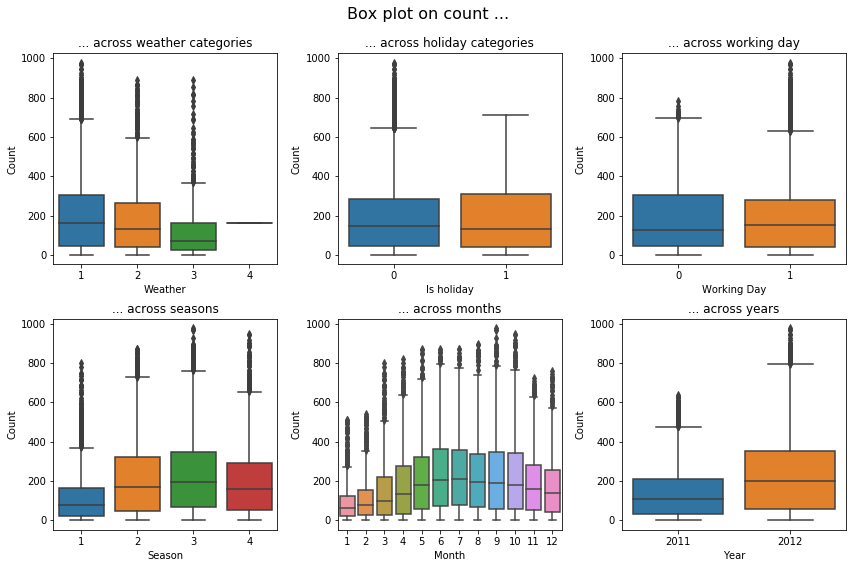

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 8)
fig.suptitle('Box plot on count ...', fontsize=16)

sn.boxplot(data=train, y="count", x="weather", orient="v", ax=axes[0][0])
axes[0][0].set(xlabel='Weather', ylabel='Count', title="... across weather categories")

sn.boxplot(data=train, y="count", x="holiday", orient="v", ax=axes[0][1])
axes[0][1].set(xlabel='Is holiday', ylabel='Count', title="... across holiday categories")

sn.boxplot(data=train,  y="count", x="workingday" ,orient="v", ax=axes[0][2])
axes[0][2].set(xlabel='Working Day', ylabel='Count', title="... across working day")

sn.boxplot(data=train, y="count", x="season", orient="v",ax=axes[1][0])
axes[1][0].set(xlabel='Season', ylabel='Count', title="... across seasons")

sn.boxplot(data=train, y="count", x="month", orient="v", ax=axes[1][1])
axes[1][1].set(xlabel='Month', ylabel='Count', title="... across months")

sn.boxplot(data=train,y="count",x="year",orient="v",ax=axes[1][2])
axes[1][2].set(xlabel='Year', ylabel='Count',title="... across years")

plt.tight_layout()
fig.subplots_adjust(top=0.9)

These plots help us investigate these outliers (values above 700 for the response variable):
- They happen on the days when people work (that is, not during the week-ends nor the holidays)
- They happen more during the warm months of the year, and when the weather is good

This indicates that outliers actually seem to be reasonnable values. For this reason, **we decide to keep them in the model**.

What's more, we notice that:
- The number of rentals is higher when the weather is nice (```weather``` = 1 or 2)
- The number of rentals is slightly higher during working days
- The number of rentals is higher during summer (```season``` = 3), and lower during winter (```season``` = 1)
- The number of rentals has been higher in 2012 than in 2011. We will come back to that.

Let us now have a look at the response variable as a function of quantitative variables:

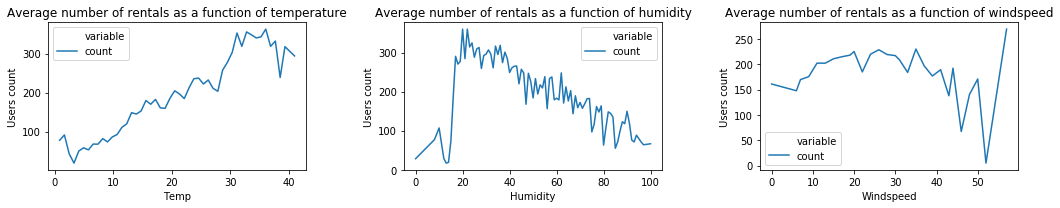

In [13]:
aggregationTemp = train.groupby("temp")["count"].mean().reset_index().melt(id_vars=["temp"])
aggregationHumidity = train.groupby("humidity")["count"].mean().reset_index().melt(id_vars=["humidity"])
aggregationWindspeed = train.groupby("windspeed")["count"].mean().reset_index().melt(id_vars=["windspeed"])

# Displaying values
fig, axes= plt.subplots(nrows=1, ncols=3, figsize = (15,3))

sn.lineplot(data=aggregationTemp, x="temp", y="value", hue="variable", hue_order=["count"], ax=axes[0])
axes[0].set(xlabel='Temp', ylabel='Users count',title="Average number of rentals as a function of temperature")

sn.lineplot(data=aggregationHumidity, x="humidity", y="value", hue="variable", hue_order=["count"], ax=axes[1])
axes[1].set(xlabel='Humidity', ylabel='Users count',title="Average number of rentals as a function of humidity")

sn.lineplot(data=aggregationWindspeed, x="windspeed", y="value", hue="variable", hue_order=["count"], ax=axes[2])
axes[2].set(xlabel='Windspeed', ylabel='Users count',title="Average number of rentals as a function of windspeed")
plt.tight_layout()

As expected, the number of rentals increases with temperature, but decreases with humidity. However, there seem to be no correlation between the number of rentals and the windspeed. We will check this later with a correlation analysis.

Let us now check the behaviour of registered users and casual users over the course of a month and over the course of a week:

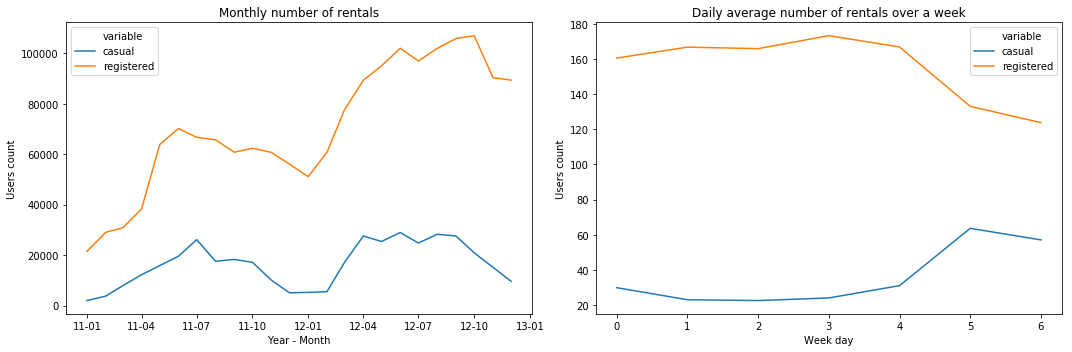

In [14]:
# Aggregating values daily, weekly and monthly
aggregationWeek = train.groupby("weekday")["casual", "registered"].mean().reset_index().melt(id_vars=["weekday"])
aggregationMonth = train.groupby("monthyear")["casual", "registered"].sum().reset_index().melt(id_vars=["monthyear"])
aggregationMonth.monthyear = [aggregationMonth.monthyear[x].to_timestamp() for x in range(aggregationMonth.shape[0])]

# Displaying values
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))

sn.lineplot(data=aggregationMonth, x="monthyear", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[0])
axes[0].set(xlabel='Year - Month', ylabel='Users count',title="Monthly number of rentals")
axes[0].xaxis.set_major_formatter(DateFormatter("%y-%m"))

sn.lineplot(data=aggregationWeek, x="weekday", y="value", hue="variable", hue_order=["casual", "registered"], ax=axes[1])
axes[1].set(xlabel='Week day', ylabel='Users count',title="Daily average number of rentals over a week")

plt.tight_layout()


We can see that the two variables are behaving similarly at the month level (they seem to increase and deacrease at the same time), but quite differently at lower levels: casual rentals occur mainly at weekends, while registered rentals occur during working days. This gives a lot of information about the users of the bike rental service.

**This indicates that we should consider building two separate models.**

What's more, the first graph indicates that the monthly retals can be very different from one year to another, showing that seasonality variables might not be the most important ones to predict the number of rentals. The overall lower level of rentals during year 2011 compared to year 2012 could be due to:

- an overall democratization trend: people just use more and more this service
- a recent launch of this service: it was not fully mature in 2011
- a different meteo in 2011 and 2012

This is just a hint that it is extremely important to include and have a careful look at other features.   
Let's now have a look at the average hourly rental count for each weekday and for each rental type (casual/registered)

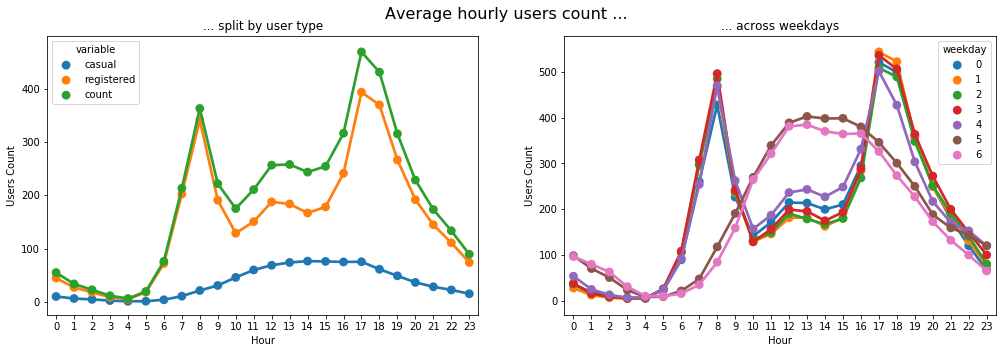

In [15]:
# Displaying the number of rentals
fig, ax= plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(17,5)
fig.suptitle('Average hourly users count ...', fontsize=16)

hourAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"], data=hourAggregated, join=True,ax=ax[1])
ax[1].set(xlabel='Hour', ylabel='Users Count',title="... across weekdays",label='big')

hourTransformed = pd.melt(train[["hour","casual","registered","count"]], id_vars=['hour'], value_vars=['casual', 'registered', 'count'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered","count"], data=hourAggregated, join=True,ax=ax[0])
ax[0].set(xlabel='Hour', ylabel='Users Count',title="... split by user type",label='big')

fig.subplots_adjust(top=0.9)

- We observe that rentals are not equally distributed over the day, which is mainly due to registered users. Indeed, we observe a completely different hourly pattern for casual vs registered users: the first plot shows that registered users are mostly people using the bikes for commuting (the peak hours for registered users are around 7-8 AM and 5-6 PM, when people go and come back from work).
- The second plot confirms that by showing that the hourly pattern is very similar for all workweek days (during which registered users are the main drivers), and very similar for weekend days (during which there are more casual users). We might not want to keep the ```weekday``` variable as it is clearly redundant with the ```workday``` variable.

<a id="Section2E"></a>
### E. Correlation analysis

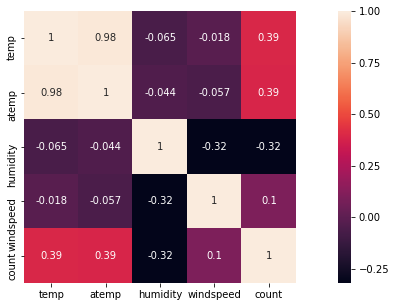

In [16]:
# Computing the correlation matrix
corrMatrix = train[["temp","atemp","humidity","windspeed","count"]].corr()

# Plotting the correlation matrix
fig,ax = plt.subplots(figsize=(15,5))
sn.heatmap(corrMatrix, square=True,annot=True)
plt.show()

```temp``` (corr = 0.39), ```atemp``` (corr = 0.39) and ```humidity``` (corr = -0.32) are quite correlated with our target variable. But given the strong correlation between ```temp``` and ```atemp``` (0.98), we should only keep one of these two.

On the other hand, one can observe that the variable ```windspeed``` has little correlation with ```count``` (corr = 0.1). This suggests that we should not include it in our model as such.  
However, we recall that more than 10% of the datasets contained strange values imputed as "0" for the variable ```windspeed```.  
Let us check the correlation matrix for the total dataset, only on the lines where ```windspeed``` is not equal to 0. 

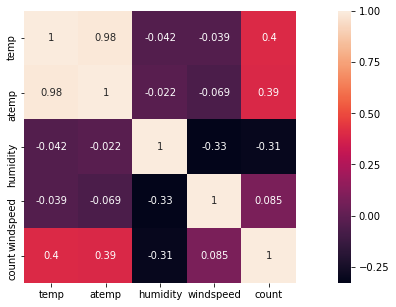

In [17]:
train_nozero = train[train['windspeed'] != 0]
corrMatrix_nozero = train_nozero[["temp","atemp","humidity","windspeed","count"]].corr()

# Plotting the correlation matrix
fig,ax = plt.subplots(figsize=(15,5))
sn.heatmap(corrMatrix_nozero, square=True,annot=True)
plt.show()

From this new correlation matrix, we can deduce that the low correlation between ```windspeed``` and  ```count``` was not due to missing values. Indeed, the correlation is even smaller in this case. This may be because when the windspeed is very low, we are not able to capture the exact windspeed, which would mean that values are Missing Not At Random. In this case, we cannot perform an imputation. 
What's more, ```windspeed``` is not correlated with atemp and temp, which means that even if we wanted to perform an imputation, we would not be able to do so in an effective way. 

**We therefore decide not to try to impute the "0" values of the ```windspeed``` variable.**  

<a id="Section4"></a>
## Prediction

<a id="Section4A"></a>
### A. Preparing the training dataset

During the explanatory data analysis, we draw conclusions on the dataset:
- We should keep outliers
- We should log-transform the response variable
- We should drop some features, such as ```datetime```, ```day```, ```humidity```, ```windspeed``` etc.

Let's thus first implement these changes.

In [18]:
# Merging the datasets
datasetsFinal = pd.concat([train, test], sort=False)

# Removing features
droppingFeatures = ["date", "windspeed", "dayoverall", "weeknumber", "weekday", "monthyear", "atemp"]
datasetsFinal = datasetsFinal.drop(droppingFeatures, axis = 1)
datasetsFinal.head()

,datetime,season,holiday,workingday,weather,temp,humidity,casual,registered,count,is_train,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,3.0,13.0,16.0,1,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,8.0,32.0,40.0,1,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,5.0,27.0,32.0,1,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,3.0,10.0,13.0,1,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1.0,1.0,1,2011,1,1,4


In [19]:
# Getting dummies
categoricalFeatures = ["season","holiday", "workingday", "weather"]
datasetsFinal = pd.get_dummies(datasetsFinal, columns = categoricalFeatures)


# Splitting training and test sets
trainFinal = datasetsFinal[datasetsFinal.is_train == 1].drop(columns=["is_train", "datetime"])
testFinal = datasetsFinal[datasetsFinal.is_train == 0].drop(columns="is_train")

trainFinal.head()

,temp,humidity,casual,registered,count,year,month,day,hour,season_1,...,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,9.84,81,3.0,13.0,16.0,2011,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
1,9.02,80,8.0,32.0,40.0,2011,1,1,1,1,...,0,0,1,0,1,0,1,0,0,0
2,9.02,80,5.0,27.0,32.0,2011,1,1,2,1,...,0,0,1,0,1,0,1,0,0,0
3,9.84,75,3.0,10.0,13.0,2011,1,1,3,1,...,0,0,1,0,1,0,1,0,0,0
4,9.84,75,0.0,1.0,1.0,2011,1,1,4,1,...,0,0,1,0,1,0,1,0,0,0


We now have 21 explanatory variables.

Note that we have made the choice not to consider the variables ```year```, ```month```, ```day```, ```hour```, as categorical variables. But we are aware that this decision could be challenged.

In [20]:
# Preparing the test dataset and the predictions file
predictions = testFinal[["datetime", "casual", "registered", "count"]]
testFinal = testFinal.drop(["casual", "registered", "count", "datetime"], axis = 1)

<a id="Section4B"></a>
### B. Selecting the models

We are going to adopt three distinct strategies to predict the number of rentals:
1. Predicting the variable ```count```
2. Predicting the variables ```casual``` and ```registered``` with the same model and summing them up
3. Predicting the variables ```casual``` and ```registered``` with a distinct model for each and summing them up

For each one of these strategies, we will compare several ML algorithms: ```LinearRegression```,```RandomForestRegressor```,```AdaBoostRegressor```,```BaggingRegressor```,```SVR```,```KNeighborsRegressor```, ```Ridge``` and ```XGBRegressor```. 

For comparing the performances of the models and of the strategies, we will compute and use their ```RMSLE```.

#### Strategy 1: Predicting ```count```

<u>**Identifying the best model**</u>

In [21]:
# Separating into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(trainFinal.drop(['count', 'registered', 'casual'],axis=1),
                                                    trainFinal['count'],
                                                    test_size=0.20,
                                                    random_state=42)

In [22]:
# Listing the models we will try
models = [RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
modelLinear= LinearRegression()
model_names = ['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
rmsleStrat1 = []

# Log-transforming the response variable
y_trainLog = np.log1p(y_train)

# Fitting the linear regression separately
modelLinear.fit(x_train, y_trainLog)
predLinear = modelLinear.predict(x_test)
rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(predLinear), y_test)))

for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_trainLog)
    pred = clf.predict(x_test)
    rmsleStrat1.append(np.sqrt(mean_squared_log_error(np.expm1(pred), y_test)))


In [23]:
# Displaying the results of this strategy
strat1 = pd.DataFrame({'Modelling Algo': model_names,'RMSLE': [round(x,3) for x in rmsleStrat1]}).sort_values(by=["Modelling Algo"])
strat1["Rank"] = strat1["RMSLE"].rank().astype(int)
strat1.sort_values(by=["Rank"])

,Modelling Algo,RMSLE,Rank
3,BaggingRegressor,0.338,1
1,RandomForestRegressor,0.346,2
7,XGBRegressor,0.382,3
4,SVR,0.589,4
2,AdaBoostRegressor,0.654,5
5,KNeighborsRegressor,0.733,6
0,LinearRegression,1.018,7
6,Ridge,1.018,7


The top three algorithms are thus **BaggingRegressor**, **RandomForestRegressor** and **XGBRegressor**. We have decided to focus on XGB.

<br>

<u>**Hyper tuning XGB**</u>

In [24]:
# Separating into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(trainFinal.drop(['count', 'registered', 'casual'],axis=1),
                                                    trainFinal['count'],
                                                    test_size=0.20,
                                                    random_state=42)

# Formatting the training sets
train_array = np.array(x_train)
target_array = np.array(y_train)

# Spliting the train dataset into 3 folds
kfold = KFold(n_splits = 3)
kfold.get_n_splits(train_array)

# Creating the sets of parameters to test
early_stopping = 50
best_score = 10
param_grid = [
              {'silent': [1],
               'nthread': [2],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [5, 7],
               'num_round': [1000],
               'subsample': [0.2, 0.4, 0.6],
               'colsample_bytree': [0.3, 0.5, 0.7],
               }
              ]


# Computing RMSLE for every set of parameter
for params in ParameterGrid(param_grid):
    print(params)
    
    ## 1. Determine best n_rounds
    xgoost_rounds = []
    for train_index, test_index in kfold.split(train_array):
        X_train, X_test = train_array[train_index], train_array[test_index]
        y_train, y_test = target_array[train_index], target_array[test_index]

        xg_train = xg.DMatrix(X_train, label=y_train)
        xg_test = xg.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        num_round = params['num_round']
        
        xgregressor = xg.train(params, xg_train, num_round, watchlist,early_stopping_rounds = early_stopping, verbose_eval = False);
        
        xgoost_rounds.append(xgregressor.best_iteration)

    num_round = int(np.mean(xgoost_rounds))
    print('The best n_rounds is %d' % num_round)
    
    ## 2. Compute RMSLE
    rmsle_score = []
    for cv_train_index, cv_test_index in kfold.split(train_array):
        X_train, X_test = train_array[cv_train_index, :], train_array[cv_test_index, :]
        y_train, y_test = target_array[cv_train_index], target_array[cv_test_index]

        xg_train = xg.DMatrix(X_train, label=y_train)
        xg_test = xg.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]

        xgregressor = xg.train(params, xg_train, num_round,verbose_eval=False);

        predicted_results = xgregressor.predict(xg_test)
        predicted_results = [0 if predicted_results[x] < 0 else predicted_results[x] for x in range(len(predicted_results))]
        rmsle_score.append(np.sqrt(mean_squared_log_error(y_test, predicted_results)))
    
    ## 3. If the RMSLE is better than the current best, best_params will take these parameters.
    if best_score > np.mean(rmsle_score):
        print(np.mean(rmsle_score))
        print('new best')
        best_score = np.mean(rmsle_score)
        best_params = params
        best_iter = num_round

{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 998
0.7055127930828045
new best
{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 999
0.6830376865750818
new best
{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 998
{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[817]	train-rmse:34.729664	test-rmse:48.546112

Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 938
0.6821763927906663
new best
{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 999
0.6696124644164797
new best
{'colsample_bytree': 0.3, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 998
0.6532077772695525
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 993
0.6175000765908906
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 993
0.5971403186476194
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 994
0.5900818606465491
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[705]	train-rmse:25.715895	test-rmse:43.422592

Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 893
0.5896147577280617
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[827]	train-rmse:21.225824	test-rmse:41.885223

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[771]	train-rmse:21.383471	test-rmse:43.179920

Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 861
0.5595198382846035
new best
{'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[638]	train-rmse:22.006901	test-rmse:43.116383

Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 878
0.5459928319920079
new best
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 991
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[908]	train-rmse:30.724487	test-rmse:42.203583



The best n_rounds is 959
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 5}


Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.
Will train until test error hasn't decreased in 50 rounds.


The best n_rounds is 992
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.2, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[921]	train-rmse:21.485168	test-rmse:41.924332

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[560]	train-rmse:25.987444	test-rmse:42.382729

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[795]	train-rmse:23.194519	test-rmse:41.146774



The best n_rounds is 758
0.531975184553693
new best
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.4, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[889]	train-rmse:17.532240	test-rmse:41.191513

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[448]	train-rmse:24.622347	test-rmse:42.854713

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[697]	train-rmse:20.785229	test-rmse:40.928532



The best n_rounds is 678
0.4911209601332968
new best
{'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}


Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[790]	train-rmse:17.085901	test-rmse:40.983078

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[640]	train-rmse:18.747112	test-rmse:42.082310

Will train until test error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[713]	train-rmse:18.694685	test-rmse:40.937653



The best n_rounds is 714
0.4813679514114522
new best


In [25]:
# Storing the best parameters
print('best params: %s' % best_params)
print('best score: %f' % best_score)
num_round = best_iter

best params: {'colsample_bytree': 0.7, 'silent': 1, 'eval_metric': 'rmse', 'subsample': 0.6, 'nthread': 2, 'objective': 'reg:linear', 'eta': 0.03, 'num_round': 1000, 'max_depth': 7}
best score: 0.481368


The best parameters are {'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}.

In [26]:
# Manually storing the best parameters (to avoid running again the grid search)
best_params_xgb = {'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 7, 'nthread': 2, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}

# Building XGBoost model
xg_train = xg.DMatrix(train_array, target_array)
watchlist = [(xg_train, 'train')]
best_xgb = xg.train(best_params_xgb, xg_train, num_round, watchlist, verbose_eval=False)

# Predicting count
test_array = np.array(testFinal)
xg_test = xg.DMatrix(test_array)
predictions["count"] = best_xgb.predict(xg_test)
predictions["count"] = np.round([0 if predictions['count'][x] < 0 else predictions['count'][x] for x in predictions['count'].index]).astype(int)

# Saving the results
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission3.csv', index=False)


As expected, **the results of this first model are not very satisfactory**. It yields a score of 0.63278 on Kaggle (2,343th over 3,251 teams).

Let's thus move on to our next strategy:

<br>

#### Strategy 2: Predicting ```registered``` and ```casual``` with the same model

<u>**Identifying the best model**</u>

In [27]:
# Separating into training and testing set
x_train_separate, x_test_separate, y_train_casual, y_test_casual = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                    trainFinal['casual'],
                                                                                    test_size=0.20,
                                                                                    random_state=42)

x_train_separate, x_test_separate, y_train_registered, y_test_registered = train_test_split(trainFinal.drop(['count', 'registered', 'casual'], axis=1),
                                                                                            trainFinal['registered'],
                                                                                            test_size=0.20,
                                                                                            random_state=42)

In [28]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['LinearRegression','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelLinear = LinearRegression()
rmsleCountStrat2 = []
rmsleCasualStrat2 = []
rmsleRegisteredStrat2 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the linear regressions separately
# 1. For casual
modelLinear.fit(X = x_train_separate,y = y_train_casualLog)
predLinearCasual = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearCasual = [0 if predLinearCasual[x] < 0 else predLinearCasual[x] for x in range(len(predLinearCasual))]
rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual), y_test_casual)))

# 2. For registered
modelLinear.fit(X = x_train_separate,y = y_train_registeredLog)
predLinearRegistered = modelLinear.predict(x_test_separate)
# Correcting the negative counts(should be null)
predLinearRegistered = [0 if predLinearRegistered[x] < 0 else predLinearRegistered[x] for x in range(len(predLinearRegistered))]
rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearRegistered), y_test_registered)))

# 3. For their sum
rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predLinearCasual) + np.expm1(predLinearRegistered),
                                                       y_test_casual + y_test_registered)))


# Fitting the other models
for model in range(len(models_separate)):
    clf = models_separate[model]
    # 1. For casual
    clf.fit(x_train_separate, y_train_casualLog)
    predCasual = clf.predict(x_test_separate)
    predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
    rmsleCasualStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
    # 2. For registered
    clf.fit(x_train_separate, y_train_registeredLog)
    predRegistered = clf.predict(x_test_separate)
    predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
    rmsleRegisteredStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
    # 3. For their sum
    rmsleCountStrat2.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                           y_test_casual + y_test_registered)))

In [29]:
strat2 = pd.DataFrame({'Modelling Algo': model_names_separate,
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat2],
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat2],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat2]}).sort_values(by=["Modelling Algo"])
strat2["Rank (by registered)"] = strat2["RMSLE - Registered"].rank().astype(int)
strat2["Rank (by casual)"] = strat2["RMSLE - Casual"].rank().astype(int)
strat2["Rank (by count)"] = strat2["RMSLE - Count"].rank().astype(int)
strat2.sort_values("Rank (by count)")

,Modelling Algo,RMSLE - Casual,RMSLE - Count,RMSLE - Registered,Rank (by registered),Rank (by casual),Rank (by count)
1,RandomForestRegressor,0.532,0.325,0.331,1,2,1
3,BaggingRegressor,0.531,0.331,0.338,2,1,2
7,XGBRegressor,0.533,0.385,0.395,3,3,3
4,SVR,0.609,0.583,0.600,4,4,4
2,AdaBoostRegressor,0.751,0.641,0.641,5,6,5
5,KNeighborsRegressor,0.720,0.733,0.753,6,5,6
0,LinearRegression,0.924,1.016,1.026,7,7,7
6,Ridge,0.924,1.016,1.026,7,7,7


The best model is **RandomForest**.

<u>**Hyper tuning the best model**</u>

**Random Forest for ```Casual```**

In [30]:
# Defining the list of parameters to test
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

 # Creating the random grid
random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

# Using the random grid to search for best hyperparameters
rf_casual = RandomForestRegressor()
rf_random_casual = RandomizedSearchCV(estimator = rf_casual, param_distributions = random_grid_rf, 
                                      n_iter = 50, cv = 3, verbose = 2, random_state = 42, n_jobs = -1,
                                      scoring = 'neg_mean_squared_log_error')

# Fit the random search model
rf_random_casual.fit(x_train_separate, y_train_casualLog)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.4min
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker time

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=2)

Best parameters: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

In [31]:
print("Best parameters: ", rf_random_casual.best_params_)

# Predicting with the best model on the test set
best_rf_casual = rf_random_casual.best_estimator_
predictions_rf_casual = best_rf_casual.predict(x_test_separate)

# Computing the results
print("RMSLE on test set: ", np.sqrt(mean_squared_log_error(np.expm1(predictions_rf_casual), y_test_casual)))

('Best parameters: ', {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 1800, 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': None})
('RMSLE on test set: ', 0.5045564796496522)


In [32]:
best_rf_casual = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = "auto", 
                                       min_samples_leaf = 2, min_samples_split = 5, n_estimators = 800)
best_rf_casual.fit(x_train_separate, y_train_casualLog)

# Predicting Casual with our SVR model
predictions["casual"] = np.expm1(best_rf_casual.predict(testFinal))
predictions["casual"] = [0 if predictions['casual'][x] < 0 else predictions['casual'][x] for x in predictions['casual'].index]

**Random Forest for ```Registered```**

In [33]:
# Defining the list of parameters to test
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

 # Creating the random grid
random_grid_rf = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

# Using the random grid to search for best hyperparameters
rf_registered = RandomForestRegressor()
rf_random_registered = RandomizedSearchCV(estimator = rf_registered, param_distributions = random_grid_rf, 
                                          n_iter = 50, cv = 3, verbose = 2, random_state = 42, n_jobs = -1,
                                          scoring = 'neg_mean_squared_log_error')

# Fit the random search model
rf_random_registered.fit(x_train_separate, y_train_registeredLog)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.9min
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/inesvanagt/anaconda3/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker time

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=2)

In [34]:
print("Best parameters: ", rf_random_registered.best_params_)

# Predicting with the best model on the test set
best_rf_registered = rf_random_registered.best_estimator_
predictions_rf_registered = best_rf_registered.predict(x_test_separate)

# Computing the results
print("RMSLE on test set: ", np.sqrt(mean_squared_log_error(np.expm1(predictions_rf_registered), y_test_registered)))

('Best parameters: ', {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 600, 'max_features': 'auto', 'min_samples_split': 5, 'max_depth': 80})
('RMSLE on test set: ', 0.32025700641273425)


What do we learn from this grid search?
1. It compared 50 combinations of parameters (it took it 21min to run).
2. It identified the following set of parameters as the best one: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}.
3. The CV RMSLE of this "best" model is 0.3203.

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try with GridSearchCV.

Last, we store our predictions.

In [35]:
# Fitting the model
best_rf_registered = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = "auto", 
                                           min_samples_leaf = 1, min_samples_split = 5, n_estimators = 600)
best_rf_registered.fit(x_train_separate, y_train_registeredLog)

# Computing count
predictions["registered"] = np.expm1(best_rf_registered.predict(testFinal))
predictions["registered"] = [0 if predictions['registered'][x] < 0 else predictions['registered'][x] for x in predictions['registered'].index]

# Computing count
predictions["count"] = np.round(predictions["registered"] + predictions["casual"]).astype(int)
predictions.head()

,datetime,casual,registered,count
10886,2011-01-20 00:00:00,1.089964,12.489783,14
10887,2011-01-20 01:00:00,0.479861,4.050642,5
10888,2011-01-20 02:00:00,0.963614,2.671020,4
10889,2011-01-20 03:00:00,0.746559,1.749262,2
10890,2011-01-20 04:00:00,0.682383,1.537817,2


In [36]:
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission2.csv', index=False)

**The results of this model are much more satisfactory**. With only two submissions, we reached the 834th position (top 25%, with a score of 0.44907).

Let's move on to our third and last strategy.

<br>

#### Strategy 3: Predicting ```registered``` and ```casual``` with distinct models

<u>**Identifying the best model**</u>

In [37]:
# Listing the models we will try
models_separate=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(), Ridge(), xg.XGBRegressor()]
model_names_separate=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor', 'Ridge', 'XGBRegressor']
modelsCasual = []
modelsRegistered = []
rmsleCountStrat3 = []
rmsleCasualStrat3 = []
rmsleRegisteredStrat3 = []


# Log transforming the response variables
y_train_casualLog = np.log1p(y_train_casual)
y_train_registeredLog = np.log1p(y_train_registered)


# Fitting the other models
for modelCasual in range(len(models_separate)):
    for modelRegistered in range(len(models_separate)):
        # 1. For casual
        clfCasual = models_separate[modelCasual]
        modelsCasual.append(model_names_separate[modelCasual])
        clfCasual.fit(x_train_separate, y_train_casualLog)
        predCasual = clfCasual.predict(x_test_separate)
        predCasual = [0 if predCasual[x] < 0 else predCasual[x] for x in range(len(predCasual))]
        rmsleCasualStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual), y_test_casual)))
        # 2. For registered
        clfRegistered = models_separate[modelRegistered]
        modelsRegistered.append(model_names_separate[modelRegistered])
        clfRegistered.fit(x_train_separate, y_train_registeredLog)
        predRegistered = clfRegistered.predict(x_test_separate)
        predRegistered = [0 if predRegistered[x] < 0 else predRegistered[x] for x in range(len(predRegistered))]
        rmsleRegisteredStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predRegistered), y_test_registered)))
        # 3. For their sum
        rmsleCountStrat3.append(np.sqrt(mean_squared_log_error(np.expm1(predCasual) + np.expm1(predRegistered),
                                                       y_test_casual + y_test_registered)))

In [38]:
strat3 = pd.DataFrame({'Model - Casual': modelsCasual,
                       'Model - Registered': modelsRegistered,
                       'RMSLE - Casual': [round(x,3) for x in rmsleCasualStrat3],
                       'RMSLE - Registered': [round(x,3) for x in rmsleRegisteredStrat3],
                       'RMSLE - Count': [round(x,3) for x in rmsleCountStrat3]}).sort_values(by=["Model - Casual"])
strat3["Rank (by casual)"] = strat3["RMSLE - Casual"].rank().astype(int)
strat3["Rank (by registered)"] = strat3["RMSLE - Registered"].rank().astype(int)
strat3["Rank (by count)"] = strat3["RMSLE - Count"].rank().astype(int)
strat3.sort_values("Rank (by count)")

,Model - Casual,Model - Registered,RMSLE - Casual,RMSLE - Count,RMSLE - Registered,Rank (by casual),Rank (by registered),Rank (by count)
0,RandomForestRegressor,RandomForestRegressor,0.530,0.330,0.336,7,3,1
16,BaggingRegressor,BaggingRegressor,0.530,0.331,0.339,7,8,2
42,XGBRegressor,RandomForestRegressor,0.533,0.332,0.338,15,6,3
14,BaggingRegressor,RandomForestRegressor,0.532,0.332,0.341,9,12,3
44,XGBRegressor,BaggingRegressor,0.533,0.334,0.340,15,10,5
2,RandomForestRegressor,BaggingRegressor,0.533,0.334,0.341,15,12,5
21,SVR,RandomForestRegressor,0.609,0.337,0.337,25,4,7
23,SVR,BaggingRegressor,0.609,0.338,0.337,25,4,8
9,AdaBoostRegressor,BaggingRegressor,0.736,0.345,0.328,39,1,9
7,AdaBoostRegressor,RandomForestRegressor,0.726,0.351,0.339,37,8,10


The best two models (with equal scores) are: 
- **Support Vector Regression** for ```Casual``` and of **Random Forest** for ```Registered```
- **Random Forest** for both

The good news is that we've already worked on the second model in Strategy 2. We thus only need to hyper tune SVR for ```Casual```.

<u>**Hyper tuning SVR for ```Casual```**</u>

In [39]:
param_grid_svr = [{'kernel': ['rbf'], 
                   'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                   'C': [1, 10, 100, 1000]}]

svr = GridSearchCV(estimator = SVR(epsilon = 0.01), param_grid = param_grid_svr, cv = 3, 
                   verbose = 2, scoring = 'neg_mean_squared_error')

svr.fit(x_train_separate, y_train_casualLog)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... kernel=rbf, C=1, gamma=0.0001, total=   3.4s
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] .................... kernel=rbf, C=1, gamma=0.0001, total=   3.3s
[CV] kernel=rbf, C=1, gamma=0.0001 ...................................
[CV] .................... kernel=rbf, C=1, gamma=0.0001, total=   3.4s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   3.5s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   3.4s
[CV] kernel=rbf, C=1, gamma=0.001 ....................................
[CV] ..................... kernel=rbf, C=1, gamma=0.001, total=   3.2s
[CV] kernel=rbf, C=1, gamma=0.01 .....................................
[CV] ...................... kernel=rbf, C=1, gamma=0.01, total=   3.6s
[CV] kernel=rbf, C=1, gamma=0.01 .....................................
[CV] ...................... kernel=rbf, C=1, gamma=0.01, total=   3.6s
[CV] kernel=rbf, C=1, gamma=0.01 .....................................
[CV] .

[CV] ..................... kernel=rbf, C=100, gamma=0.1, total=  13.4s
[CV] kernel=rbf, C=100, gamma=0.2 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.2, total=   8.5s
[CV] kernel=rbf, C=100, gamma=0.2 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.2, total=   8.7s
[CV] kernel=rbf, C=100, gamma=0.2 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.2, total=   8.5s
[CV] kernel=rbf, C=100, gamma=0.5 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.5, total=   5.4s
[CV] kernel=rbf, C=100, gamma=0.5 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.5, total=   5.2s
[CV] kernel=rbf, C=100, gamma=0.5 ....................................
[CV] ..................... kernel=rbf, C=100, gamma=0.5, total=   5.2s
[CV] kernel=rbf, C=100, gamma=0.6 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 50.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [40]:
print("Best parameters: ", svr.best_params_)

('Best parameters: ', {'kernel': 'rbf', 'C': 10, 'gamma': 0.01})


The best parameters found for SVR are C = 10, gamma = 0.01 and kernel = rbf.

In [41]:
# Fitting the model
best_svr = SVR(C = 1, gamma = 0.1, kernel = 'rbf')
best_svr.fit(x_train_separate, y_train_casualLog)

# Storing the predictions
predictions["casual"] = np.expm1(best_svr.predict(testFinal))
predictions["casual"] = [0 if predictions['casual'][x] < 0 else predictions['casual'][x] for x in predictions['casual'].index]

predictions["count"] = np.round(predictions["registered"] + predictions["casual"]).astype(int)
predictions.head()

,datetime,casual,registered,count
10886,2011-01-20 00:00:00,12.272211,12.489783,25
10887,2011-01-20 01:00:00,11.483144,4.050642,16
10888,2011-01-20 02:00:00,10.572393,2.671020,13
10889,2011-01-20 03:00:00,9.593920,1.749262,11
10890,2011-01-20 04:00:00,8.677923,1.537817,10


In [42]:
kaggle_file = predictions[["datetime", "count"]]
kaggle_file.head()
kaggle_file.to_csv('submission1.csv', index=False)

**Surprisingly, this model performs poorly**: it ranks in the top 65% on Kaggle.

How can we explain that? We believe this comes from the way we ranked the combinations of models earlier on. We separated the training set into two subsets (80/20%). We used the first one as the training set, and the second one as the test set. We then fitted our models on the training set, and computed their performances on the test set using the ```RMSLE```.

SVR is probably performing well on the test set we obtained, but does not generalize. This means it does not perform as well on other datasets.

On the other hand, Random Forest performed well both on the test set we built ourselves, and on the one provided by Kaggle. This is why it ranked among the top 25% models.

<a id="Section4"></a>
## 4. Conclusion and next steps

Using random forests, we managed to predict bike sharing demand with a CV RMSLE of 0.3203. We got a Kaggle score of 0.44907 and ranked among the top 25% models.

The next steps would be the following:
- from a technical point of view, our model could be improved by trying some models that are specific to time-series: ARIMA models, LSTM neural-networks...
- from a business point of view, our predictions could be used as a way to better schedule the maintenance or transportation of bikes from one station to another ; it could also show how many additional bikes could be required in the future ; ...